# Consumo de Bateria Correta: Buscando Solução para o Problema


## Importação de Bibliotecas: Matplotlib e Z3


In [11]:
# Importa a biblioteca Matplotlib, que é usada para criar visualizações gráficas de dados.
# O módulo 'pyplot' fornece uma interface semelhante à do MATLAB para criar gráficos.
import matplotlib.pyplot as plt

# Importa a biblioteca Z3, que é um solver SMT (Satisfiability Modulo Theories) usado para resolver problemas lógicos e de otimização.
# 'from z3 import *' importa todas as funções e classes do Z3 diretamente no escopo global do código,
# permitindo trabalhar com expressões lógicas, variáveis simbólicas e constraints matemáticas.
from z3 import *

## Configuração do Grid do Armazém e Posição Inicial do Drone


In [12]:
# Definindo os parâmetros que podem ser editados de acordo com a necessidade
num_rows = 4       # Número de "linhas" ou grupos de coordenadas no eixo X (quantidade de linhas no grid do armazém)
num_columns = 5    # Número de colunas de coordenadas no eixo Y (quantidade de colunas no grid do armazém)
x_step = 2         # Distância entre as "linhas" no eixo X (define o espaçamento horizontal entre os pontos)
x_offset = 3       # Deslocamento (offset) inicial no eixo X (define onde a primeira linha do grid começa no eixo X)
y_offset = 1       # Deslocamento (offset) inicial no eixo Y (define onde a primeira coluna do grid começa no eixo Y)

# Lista para armazenar todas as coordenadas do armazém
warehouse = []  # Inicializa uma lista vazia que armazenará todas as coordenadas dos pontos no armazém

# Criação das coordenadas do armazém (grid de posições)
for i in range(num_rows):  # Loop externo que percorre as linhas (grupos no eixo X)
    # 'i' representa o índice de cada linha que será criada
    for j in range(num_columns):  # Loop interno que percorre as colunas (grupos no eixo Y)
        # 'j' representa o índice de cada coluna dentro da linha correspondente
        
        x = x_step * i + x_offset  # Cálculo da coordenada X: multiplica o índice da linha pelo espaçamento e adiciona o deslocamento inicial
        y = j + y_offset           # Cálculo da coordenada Y: usa o índice da coluna e adiciona o deslocamento inicial
        
        warehouse.append((x, y))   # Adiciona a tupla (x, y) à lista de coordenadas do armazém

# Exibe a lista de coordenadas geradas para o armazém
print("Coordenadas do armazém:", warehouse)

# Definição da posição inicial do drone
drone = (0, 0)  # O drone começa na posição (0,0), mas esse valor pode ser alterado conforme necessário
print("Posição inicial do drone:", drone)


Coordenadas do armazém: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
Posição inicial do drone: (0, 0)


## Visualização do Grid do Armazém e da Posição Inicial do Drone


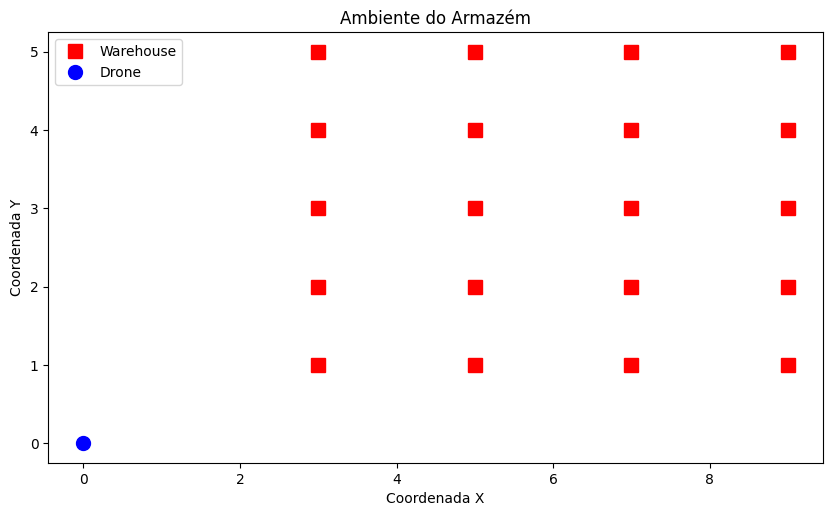

In [13]:
# Criação da figura e do eixo do gráfico
fig, ax = plt.subplots(figsize=(10, 6))  
# 'fig' representa a figura do Matplotlib, que contém o gráfico
# 'ax' é o eixo do gráfico onde os elementos serão desenhados
# figsize=(10, 6) define o tamanho da figura em polegadas (largura x altura)

# Plotagem dos pontos representando as coordenadas do armazém
ax.plot(
    [x for x, y in warehouse],  # Extrai todas as coordenadas X da lista warehouse
    [y for x, y in warehouse],  # Extrai todas as coordenadas Y da lista warehouse
    'rs',  # Define o marcador como um quadrado vermelho ('r' = red, 's' = square)
    markersize=10,  # Define o tamanho dos marcadores no gráfico
    label='Warehouse'  # Define o rótulo para a legenda do gráfico
)

# Plotagem da posição inicial do drone
ax.plot(
    drone[0],  # Coordenada X do drone
    drone[1],  # Coordenada Y do drone
    'bo',  # Define o marcador como um círculo azul ('b' = blue, 'o' = circle)
    markersize=10,  # Define o tamanho do marcador do drone
    label='Drone'  # Define o rótulo para a legenda do gráfico
)

# Adiciona um título ao gráfico
ax.set_title('Ambiente do Armazém')

# Define os rótulos dos eixos do gráfico
ax.set_xlabel('Coordenada X')  # Nome do eixo X
ax.set_ylabel('Coordenada Y')  # Nome do eixo Y

# Configura os eixos para ter a mesma escala, garantindo que as distâncias sejam proporcionais
ax.set_aspect('equal')

# Exibe a legenda no gráfico, utilizando os rótulos definidos nos plots
ax.legend()

# Exibe o gráfico na tela
plt.show()

# Otimização da Trajetória do Drone no Armazém com o Solver Z3

unsat timesteps: 1
unsat timesteps: 2
unsat timesteps: 3
unsat timesteps: 4
unsat timesteps: 5
unsat timesteps: 6
unsat timesteps: 7
unsat timesteps: 8
unsat timesteps: 9
unsat timesteps: 10
unsat timesteps: 11
unsat timesteps: 12
unsat timesteps: 13
unsat timesteps: 14
unsat timesteps: 15
unsat timesteps: 16
unsat timesteps: 17
unsat timesteps: 18
unsat timesteps: 19
unsat timesteps: 20
unsat timesteps: 21
unsat timesteps: 22
unsat timesteps: 23
unsat timesteps: 24
unsat timesteps: 25
unsat timesteps: 26
unsat timesteps: 27
unsat timesteps: 28
unsat timesteps: 29
unsat timesteps: 30
unsat timesteps: 31
sat timesteps: 32
Solução encontrada com 32 timesteps mínimos:

Trajetória do Drone:
Passo 0: Posição (0, 0), Bateria 100
Passo 1: Posição (1, 0), Bateria 98
Passo 2: Posição (2, 0), Bateria 96
Passo 3: Posição (3, 1), Bateria 93
Passo 4: Posição (4, 0), Bateria 90
Passo 5: Posição (5, 1), Bateria 87
Passo 6: Posição (6, 1), Bateria 85
Passo 7: Posição (7, 2), Bateria 82
Passo 8: Posiçã

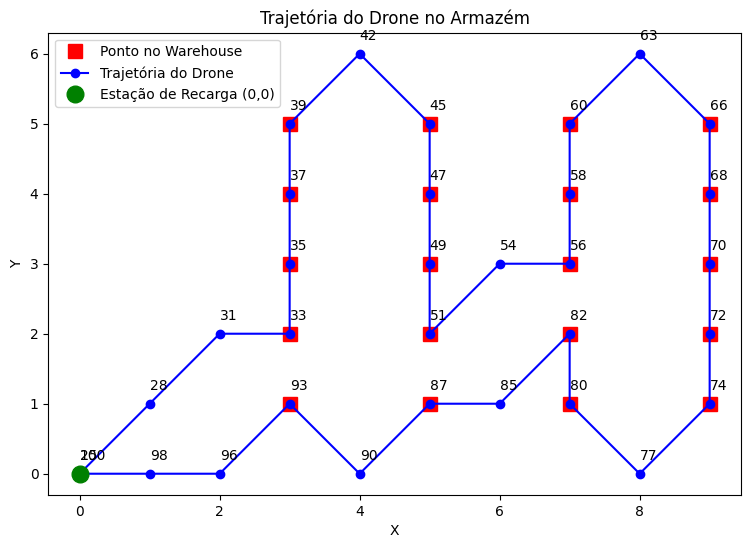

In [14]:
# Define a função que tenta encontrar uma solução com o mínimo de timesteps utilizando o solver Z3
def solve_with_min_timesteps(max_timesteps, bmax, gridx, gridy, warehouse):
    # Itera sobre possíveis números de timesteps, começando de 1 até o máximo permitido
    for timesteps in range(1, max_timesteps + 1):
        s = Solver()  # Cria uma nova instância do solver Z3 para o número atual de timesteps

        # Cria uma lista de variáveis inteiras representando a coordenada X do drone em cada timestep
        PGx = [Int(f'pgx_{k}') for k in range(timesteps)]
        # Cria uma lista de variáveis inteiras representando a coordenada Y do drone em cada timestep
        PGy = [Int(f'pgy_{k}') for k in range(timesteps)]
        # Cria uma lista de variáveis inteiras representando o nível de bateria do drone em cada timestep
        Bat = [Int(f'bat_{k}') for k in range(timesteps)]

        # Para cada variável de bateria, adiciona uma restrição para que o valor esteja entre 1 e bmax
        for b in Bat:
            s.add(And(b >= 1, b <= bmax))
        # Para cada variável de coordenada X, adiciona restrição para que esteja entre 0 e gridx (limites do grid)
        for x in PGx:
            s.add(And(x >= 0, x <= gridx))
        # Para cada variável de coordenada Y, adiciona restrição para que esteja entre 0 e gridy (limites do grid)
        for y in PGy:
            s.add(And(y >= 0, y <= gridy))

        # Define a condição inicial: o drone começa na posição (0,0) com bateria cheia (bmax)
        s.add(PGx[0] == 0)  # Posição X inicial é 0
        s.add(PGy[0] == 0)  # Posição Y inicial é 0
        s.add(Bat[0] == bmax)  # Bateria inicial é a máxima permitida (bmax)

        # Para cada timestep a partir do segundo (índice 1) adiciona restrições de movimento e consumo de bateria
        for k in range(1, timesteps):
            # O drone pode mover-se na coordenada X: aumenta, diminui ou permanece igual à posição anterior
            s.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))
            # O drone pode mover-se na coordenada Y: aumenta, diminui ou permanece igual à posição anterior
            s.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))
            # Impede que o drone fique parado, ou seja, que as coordenadas X e Y não se mantenham as mesmas
            s.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))

            # Define a regra de consumo de bateria dependendo do tipo de movimento realizado:
            # Se o movimento for diagonal (mudança em X e Y simultaneamente) consome 3 unidades;
            # se for movimento em linha reta (mudança apenas em X ou apenas em Y) consome 2 unidades;
            # se não houver movimento, a bateria permanece inalterada (embora essa situação seja evitada pela restrição acima).
            s.add(If(
                Or(
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),  # Movimento diagonal: para cima e para a direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),  # Movimento diagonal: para baixo e para a esquerda
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),  # Movimento diagonal: para baixo e para a direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)   # Movimento diagonal: para cima e para a esquerda
                ),
                Bat[k] == Bat[k-1] - 3,  # Consome 3 unidades de bateria em movimento diagonal
                If(
                    Or(
                        And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),  # Movimento para a direita
                        And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),  # Movimento para a esquerda
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1),  # Movimento para cima
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1)   # Movimento para baixo
                    ),
                    Bat[k] == Bat[k-1] - 2,  # Consome 2 unidades de bateria em movimento em linha reta
                    Bat[k] == Bat[k-1]       # Se não houve movimento (não deve ocorrer), a bateria não é consumida
                )
            ))

        # Para cada ponto (x,y) definido no armazém, adiciona restrição para que o drone passe por esse ponto em algum timestep
        for (x, y) in warehouse:
            s.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))

        # Adiciona restrição para que, no último timestep, o drone retorne à posição inicial (0,0)
        s.add(PGx[timesteps - 1] == 0)  # No último passo, a posição X deve ser 0
        s.add(PGy[timesteps - 1] == 0)  # No último passo, a posição Y deve ser 0

        # Verifica se o conjunto de restrições é satisfatível (existe solução para o número atual de timesteps)
        if s.check() == sat:
            print(s.check(), "timesteps:", timesteps)  # Exibe no console o resultado da verificação e o número de timesteps
            m = s.model()  # Se satisfatível, obtém o modelo (solução) do solver
            print("Solução encontrada com", timesteps, "timesteps mínimos:")  # Informa o usuário que uma solução foi encontrada
            return m, timesteps, PGx, PGy, Bat  # Retorna o modelo, o número de timesteps e as listas de variáveis
        else:
            print(s.check(), "timesteps:", timesteps) # Exibe no console o resultado da verificação e o número de timesteps

    # Se nenhuma solução foi encontrada para qualquer número de timesteps até o máximo permitido:
    print("Nenhuma solução encontrada até", max_timesteps, "timesteps.")
    return None, None, None, None, None  # Retorna valores nulos indicando falha em encontrar solução

# Define os parâmetros do problema:
max_timesteps = 100  # Número máximo de timesteps que serão testados
bmax = 100  # Capacidade máxima da bateria
gridx = 9  # Tamanho do grid no eixo X (posição máxima)
gridy = 10  # Tamanho do grid no eixo Y (posição máxima)

# Chama a função para resolver o problema e obtém o modelo e as variáveis associadas
model, timesteps, PGx, PGy, Bat = solve_with_min_timesteps(max_timesteps, bmax, gridx, gridy, warehouse)

# Se uma solução foi encontrada (model não é None), prossegue para extrair e exibir os resultados
if model:
    # Avalia e extrai os valores da coordenada X para cada timestep a partir do modelo
    pgx_values = [model.evaluate(PGx[k]).as_long() for k in range(timesteps)]
    # Avalia e extrai os valores da coordenada Y para cada timestep a partir do modelo
    pgy_values = [model.evaluate(PGy[k]).as_long() for k in range(timesteps)]
    # Avalia e extrai os valores da bateria para cada timestep a partir do modelo
    bat_values = [model.evaluate(Bat[k]).as_long() for k in range(timesteps)]

    # Imprime no console a trajetória do drone passo a passo
    print("\nTrajetória do Drone:")
    for t in range(timesteps):
        # Exibe o passo, a posição (x, y) e o nível da bateria para aquele timestep
        print(f"Passo {t}: Posição ({pgx_values[t]}, {pgy_values[t]}), Bateria {bat_values[t]}")

    # Cria uma figura e um eixo para plotar a trajetória do drone usando o Matplotlib
    fig, ax = plt.subplots(figsize=(10, 6))

    # Itera sobre cada ponto do armazém para plotá-los no gráfico
    for i, (x, y) in enumerate(warehouse):
        # Se for o primeiro ponto, plota com um rótulo para a legenda
        if i == 0:
            ax.plot(x, y, 'rs', markersize=10, label="Ponto no Warehouse")
        else:
            # Para os demais pontos, plota sem o rótulo
            ax.plot(x, y, 'rs', markersize=10)

    # Plota a trajetória do drone conectando os pontos obtidos (linha azul com marcadores circulares)
    ax.plot(pgx_values, pgy_values, 'b-o', label="Trajetória do Drone")
    # Plota o ponto de recarga (posição inicial 0,0) com um marcador verde maior
    ax.plot(0, 0, 'go', markersize=12, label="Estação de Recarga (0,0)")

    # Para cada passo da trajetória, adiciona um texto próximo ao ponto mostrando o nível de bateria
    for i in range(timesteps):
        # O texto é posicionado um pouco acima do ponto (y + 0.2) para melhor visualização
        ax.text(pgx_values[i], pgy_values[i] + 0.2, f'{bat_values[i]}', fontsize=10)

    # Define o rótulo do eixo X
    plt.xlabel("X")
    # Define o rótulo do eixo Y
    plt.ylabel("Y")
    # Define o título do gráfico
    plt.title("Trajetória do Drone no Armazém")
    # Exibe a legenda que identifica os elementos do gráfico
    plt.legend()
    # Configura os eixos para terem a mesma escala (proporção igual)
    ax.set_aspect('equal')
    # Exibe o gráfico na tela
    plt.show()